In [1]:
import uproot
import awkward
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

from tqdm import tqdm_notebook as tqdm
mpl.rcParams['figure.dpi'] = 300

In [2]:
# muon default_PDGid13_x0_E1.0To1000.0_NTUP_19.root   
# photon default_PDGid22_x0_E1.0To1000.0_NTUP_71.root
# pion default_PDGid211_x0_E1.0To1000.0_NTUP_85.root
#fname = '/eos/uscms/store/user/sghosh/HFNFILES/default_PDGid22_x0_E1.0To1000.0_NTUP_21.root'
fname = '/eos/uscms/store/user/sghosh/HFNFILES/newsamples/default_PDGid22_x0_E1.0To1000.0_NTUP_7.root'

#rootfile = uproot.open(fname).counts
rootfile = uproot.open(fname)['ana']['hgc']
figs = []

In [3]:
rootfile.keys()

[b'event',
 b'lumi',
 b'run',
 b'vtx_x',
 b'vtx_y',
 b'vtx_z',
 b'genpart_eta',
 b'genpart_phi',
 b'genpart_pt',
 b'genpart_energy',
 b'genpart_dvx',
 b'genpart_dvy',
 b'genpart_dvz',
 b'genpart_fbrem',
 b'genpart_pid',
 b'genpart_gen',
 b'genpart_reachedEE',
 b'genpart_fromBeamPipe',
 b'genpart_posx',
 b'genpart_posy',
 b'genpart_posz',
 b'rechit_eta',
 b'rechit_phi',
 b'rechit_pt',
 b'rechit_energy',
 b'rechit_x',
 b'rechit_y',
 b'rechit_z',
 b'rechit_time',
 b'rechit_thickness',
 b'rechit_layer',
 b'rechit_wafer_u',
 b'rechit_wafer_v',
 b'rechit_cell_u',
 b'rechit_cell_v',
 b'rechit_detid',
 b'rechit_isHalf',
 b'rechit_flags',
 b'rechit_cluster2d',
 b'rechit_radius',
 b'cluster2d_eta',
 b'cluster2d_phi',
 b'cluster2d_pt',
 b'cluster2d_energy',
 b'cluster2d_x',
 b'cluster2d_y',
 b'cluster2d_z',
 b'cluster2d_layer',
 b'cluster2d_nhitCore',
 b'cluster2d_nhitAll',
 b'cluster2d_multicluster',
 b'cluster2d_rechits',
 b'cluster2d_rechitSeed',
 b'multiclus_eta',
 b'multiclus_phi',
 b'multic

In [27]:
rechit = rootfile.arrays([b'rechit_thickness', b'rechit_energy',  b'rechit_layer',  b'rechit_time',b'rechit_x', b'rechit_y', b'rechit_z', b'rechit_eta', b'rechit_phi'])
rechit[b'rechit_x'].content[rechit[b'rechit_z'].content < 0] *= -1
#rechit[b'rechit_layer'].content[rechit[b'rechit_layer'].content < 0] *= -10
#rechit[b'rechit_x']= rechit[b'rechit_x'][rechit[b'rechit_z'] > 0] 
NEvents = rechit[b'rechit_z'].shape[0]
#simcluster = rootfile.arrays([b'simcluster_hits_indices',  b'simcluster_energy', b'simcluster_eta', b'simcluster_phi', b'simcluster_layers', b'simcluster_pid'])
simcluster = rootfile.arrays([b'simcluster_hits_indices',  b'simcluster_energy', b'simcluster_eta', b'simcluster_phi', b'simcluster_layers'])

In [28]:
print (NEvents)
evt =0
print (len(simcluster[b'simcluster_hits_indices'][evt]))
print(simcluster[b'simcluster_energy'][evt].shape)
print(rechit[b'rechit_energy'][evt].shape)

96
6
(6,)
(20683,)


In [29]:
## positive sim indices (-ve for non rechit)
sim_indices = awkward.fromiter(simcluster[b'simcluster_hits_indices'])
valid_sim_indices = sim_indices[sim_indices > -1]


In [30]:
#all_sim_hits = np.unique(valid_sim_indices[0].flatten())
#print ('all_sim_hits\n',all_sim_hits)
#sim_hits_mask = np.zeros(rechit[b'rechit_z'][0].size, dtype=np.bool)
#print ('sim_hits_mask\n',sim_hits_mask)
#sim_hits_mask[all_sim_hits] = True
#print ('sim_hits_mask\n',sim_hits_mask)
#simmatched = np.where(sim_hits_mask)
#print ('simmatched\n',simmatched)

In [31]:
## simclusters mask for rechit number and energy 
simcluster_rechit_cut = 3 #min no. of rechits in simcluster requirement (exclusive)
simcluster_mask = awkward.JaggedArray.fromcounts(valid_sim_indices.counts,valid_sim_indices.flatten().counts > simcluster_rechit_cut)
simcluster_mask = simcluster_mask & (simcluster[b'simcluster_energy'] > 1.0)
valid_sim_indices = valid_sim_indices[simcluster_mask]
for key, value in simcluster.items():
    if (key == b'simcluster_hits_indices'): continue
    simcluster[key] = awkward.fromiter(value)[simcluster_mask]

In [32]:
valid_sim_indices_eventlevel = valid_sim_indices.flatten(1)
valid_sim_indices_eventlevel = awkward.fromiter(map(np.unique, valid_sim_indices_eventlevel))
#valid_sim_indices_eventlevel[0]

In [33]:
## rechits matched with simhits
simmatched_rechit = {}
for key, value in rechit.items():
    simmatched_rechit[key] = value[valid_sim_indices_eventlevel]

In [34]:
## rechits organised in simhit indices structure

def rewrap_into_simcluster_structure(filelevel_array):
    return awkward.JaggedArray.fromcounts(valid_sim_indices.counts,\
        (awkward.JaggedArray.fromcounts(valid_sim_indices.content.counts, filelevel_array)))

rechit_simcluster = {}
select_rechit_simcluster = [b'rechit_energy', b'rechit_layer', b'rechit_eta', b'rechit_phi']
for key, value in rechit.items():
    if key not in select_rechit_simcluster: continue
    rechit_simcluster[key] = value[valid_sim_indices.flatten(1)]
    rechit_simcluster[key] = rewrap_into_simcluster_structure(rechit_simcluster[key].content)
    
#corrected_rechit_simcluster_energy = rechit_simcluster[b'rechit_energy'] * rewrap_into_simcluster_structure(np.take(absorber_weights,rechit_simcluster[b'rechit_layer'].content.content))
corrected_rechit_simcluster_energy = rechit_simcluster[b'rechit_energy']

In [35]:
#print (rechit[b'rechit_energy'][valid_sim_indices.flatten(1)].content.shape)
#print (sum(valid_sim_indices.content.counts))
#print (valid_sim_indices.flatten(1)[0].shape)
#print (valid_sim_indices[0].counts)

In [36]:
## plotting functions

def plotHist(axes, data, xlabel, ylabel, title, Nbins = 100, range=None, xlog=False, ylog=False):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_title(title)
    if xlog:
        axes.set_xscale('log')
        Nbins = np.logspace(np.log10(data.min()),np.log10(data.max()),Nbins)
    return axes.hist(data, bins=Nbins, range=range, histtype='step', log=ylog); 
    
def plotHist_absxlog(axes, data, xlabel, ylabel, title, Nbins = 100, ylog=False):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_title(title)
    axes.set_xscale('log')
    Nbins = np.logspace(np.log10(np.abs(data).min()),np.log10(np.abs(data).max()),Nbins)
    axes.hist(data, bins=Nbins, histtype='step', log=ylog); 
    
def plotHist_layers(data, ylabel, title, xlabel="Layer", log=True):
    fig,axes = plt.subplots(figsize=(10, 7));
    axes.set_xlabel(xlabel)
    axes.set_xticks(np.arange(53)+0.5, minor=True)
    axes.set_ylabel(ylabel)
    axes.set_title(title)
    axes.hist(data, range=(0,60), bins=np.arange(62)-0.5, log=log, histtype='step', linewidth = '1.5');
    plt.grid(True, which='minor', axis='x', linewidth='0.5')
    return fig



def plotRechitEnergy_Thickness(thickness, rechit_energy, rechit_thickness, title_target):
    title = '%s Energy Distribution for HFN' % (title_target)
#    e = rechit_energy.flatten()
    if thickness == 100:
        e = rechit_energy.flatten()[rechit_thickness.flatten() < 200]
#       e = rechit_pd[(rechit_pd[b'rechit_thickness'] > 99.0) & (rechit_pd[b'rechit_thickness'] < 121.0)][b'rechit_energy']
#    if thickness == 200:
        #e = rechit_pd[(rechit_pd[b'rechit_thickness'] > 199.0) & (rechit_pd[b'rechit_thickness'] < 201.0)][b'rechit_energy']
#        e = rechit_energy.flatten()[(rechit_thickness.flatten() > 199.0) & (rechit_thickness.flatten() < 201.0)]
#    if thickness == 300:
        #e = rechit_pd[(rechit_pd[b'rechit_thickness'] > 299.0) & (r301echit_pd[b'rechit_thickness'] < 301.0)][b'rechit_energy']
#        e = rechit_energy.flatten()[(rechit_thickness.flatten() > 299.0) & (rechit_thickness.flatten() < 301.0)]
    if thickness == -1:
        #e = rechit_pd[(rechit_pd[b'rechit_thickness'] > 301.0)][b'rechit_energy']
        e = rechit_energy.flatten()[rechit_thickness.flatten() > 200.0]
        title = "%s Energy Distribution for HF" % (title_target)
    
    fig = plt.figure(figsize=(17,5));
    ax1 = fig.add_subplot(121);
    plotHist(ax1, e, 'Energy/GeV', 'Rechits', title, Nbins = 100, ylog=True)
#    ax2 = fig.add_subplot(122);
#    plotHist(ax2, e, 'Energy/GeV', 'Rechits', title, Nbins = 100, xlog=True, ylog=True)
    return fig;

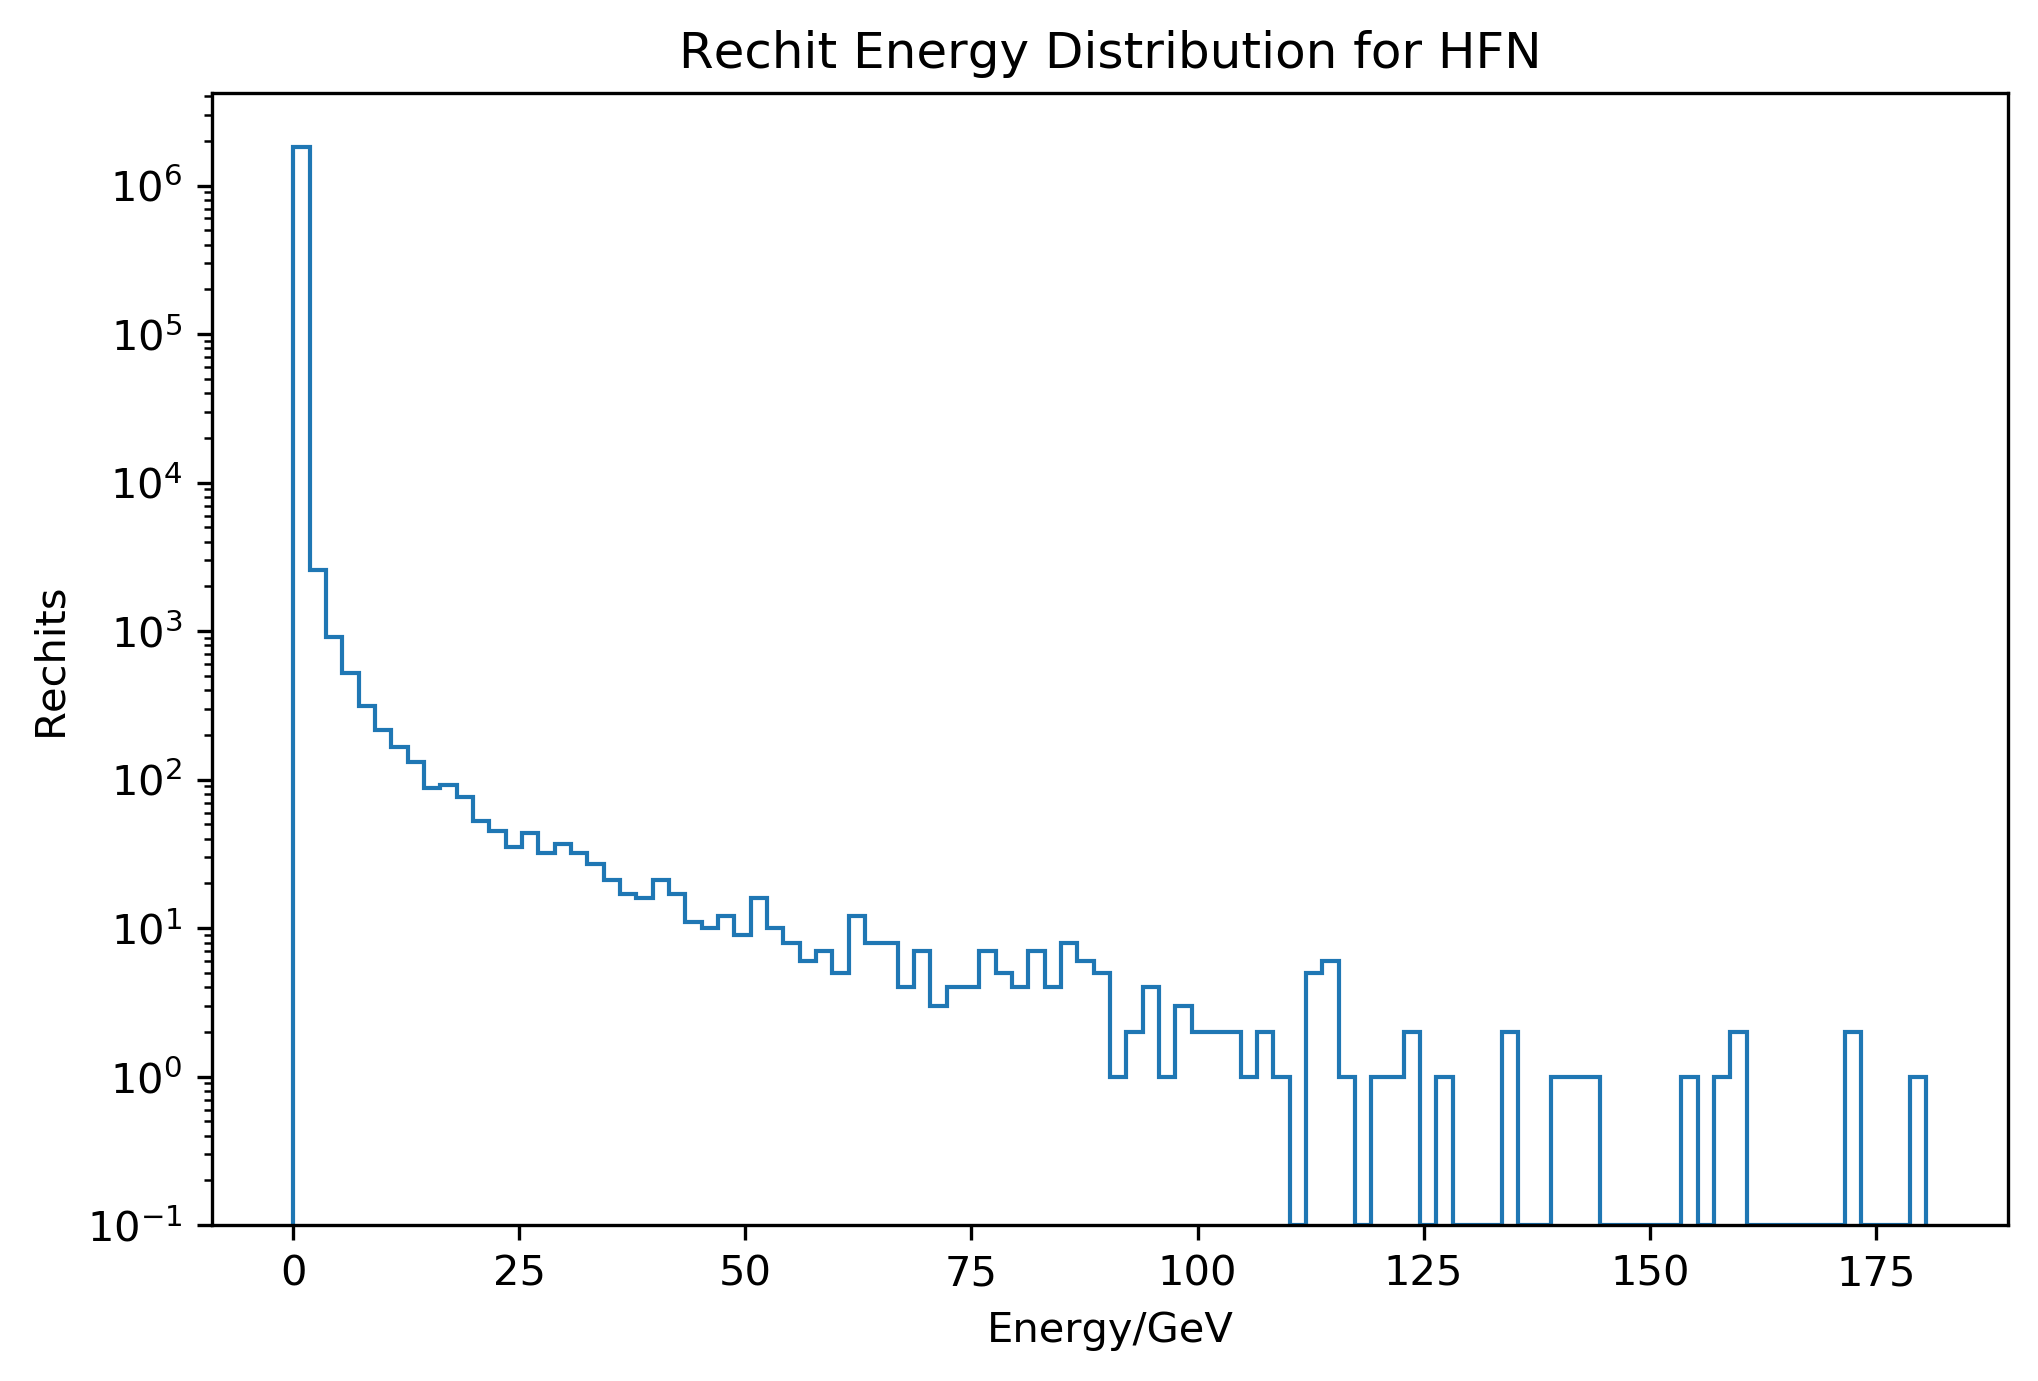

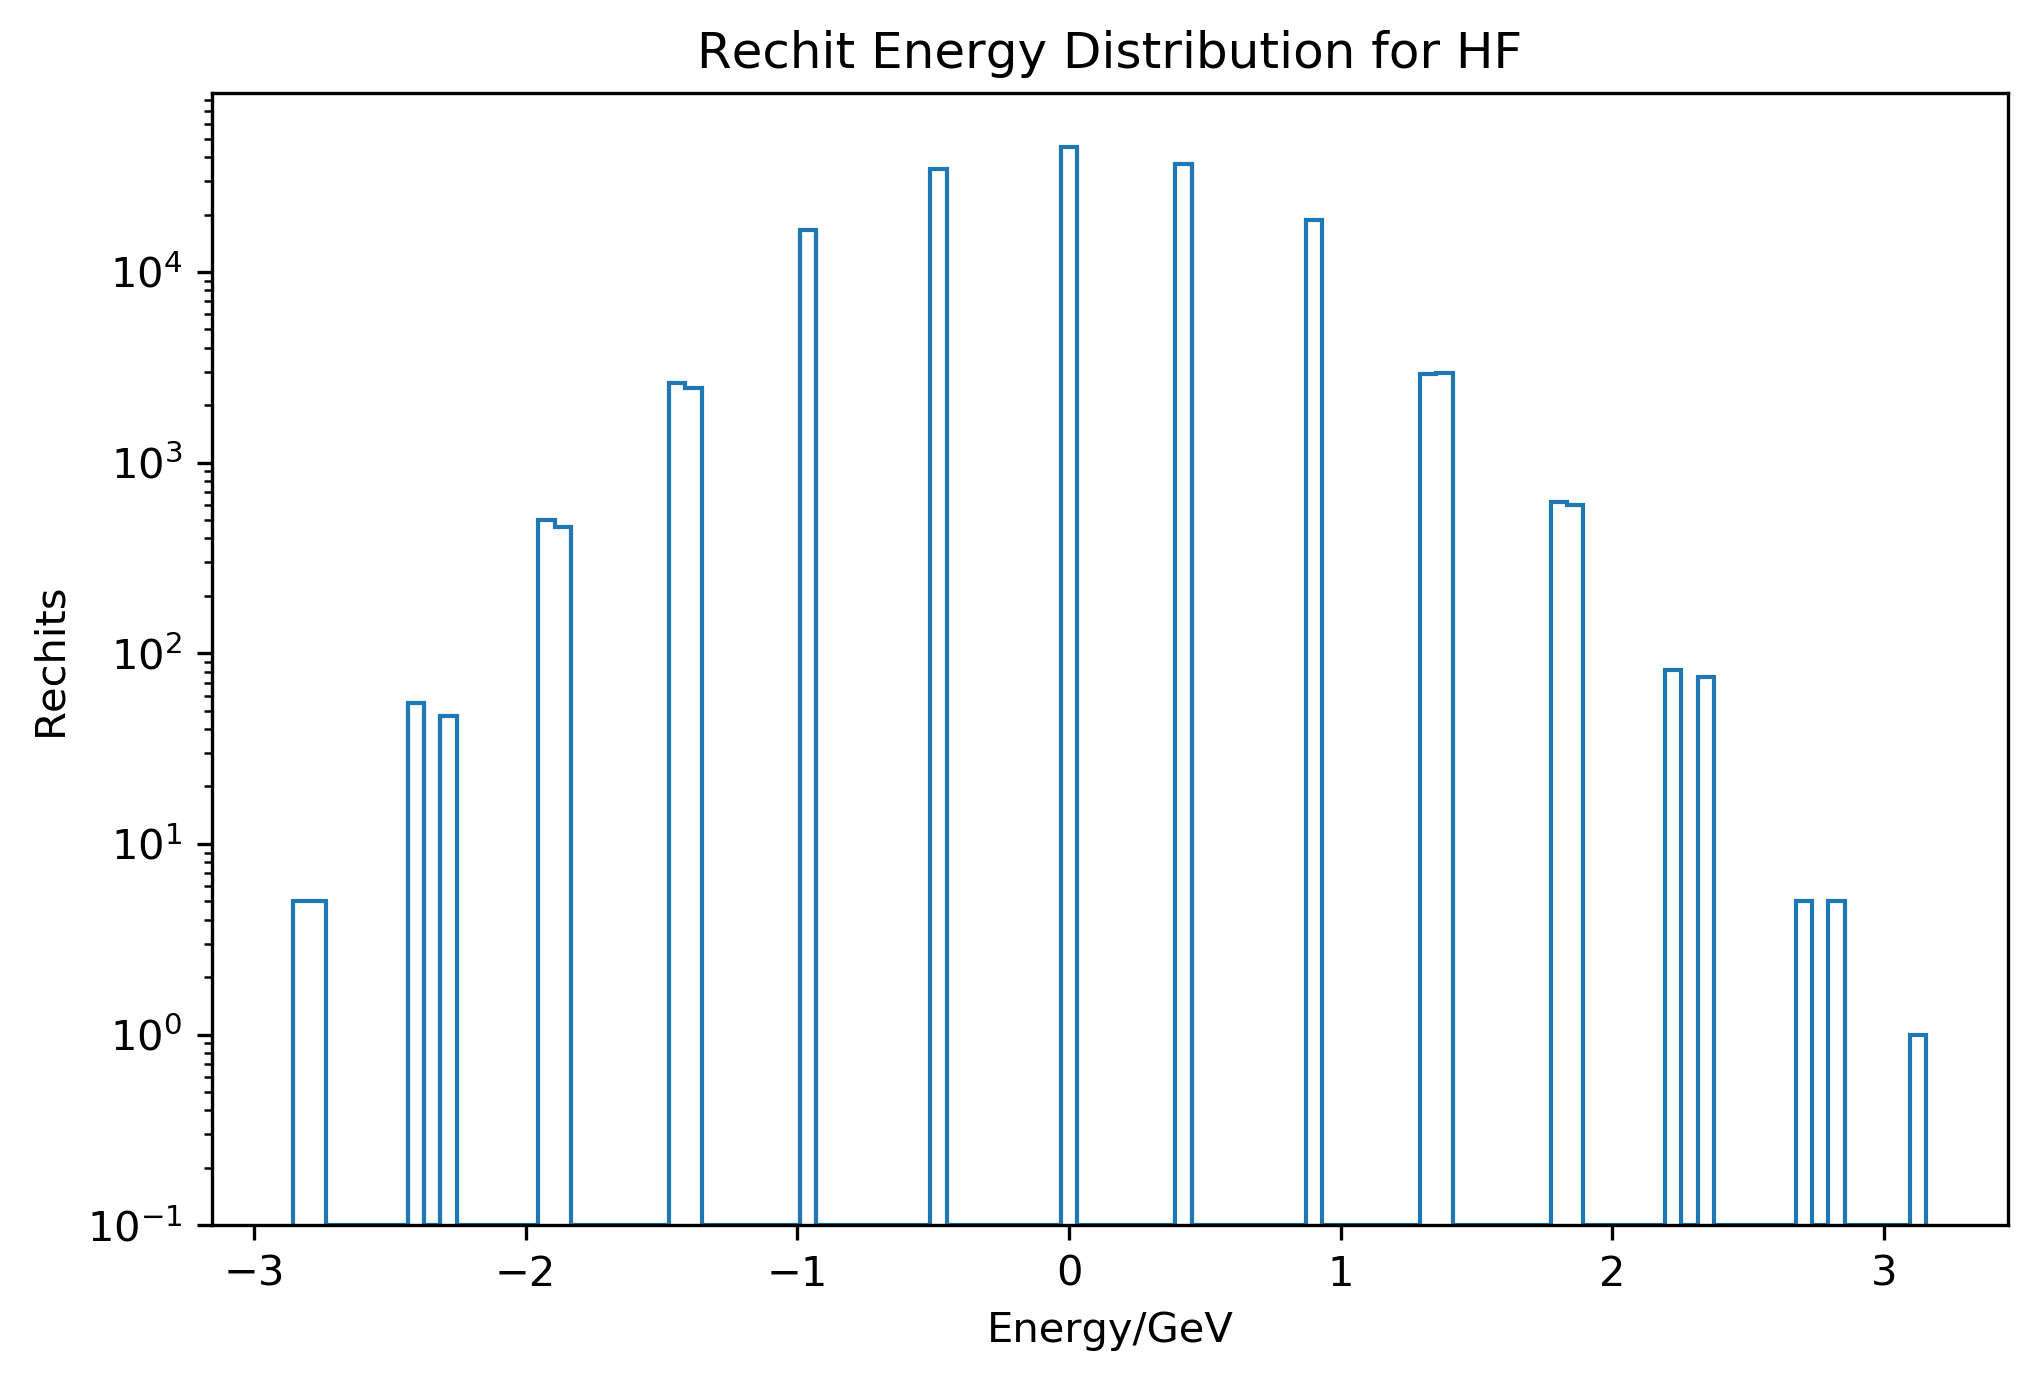

In [37]:
figs.append(plotRechitEnergy_Thickness(100, rechit[b'rechit_energy'], rechit[b'rechit_thickness'], "Rechit"));
figs.append(plotRechitEnergy_Thickness(-1, rechit[b'rechit_energy'], rechit[b'rechit_thickness'], "Rechit"));
#figs.append(plotRechitEnergy_Thickness(300, rechit[b'rechit_energy'], rechit[b'rechit_thickness'], "Rechit"));
#figs.append(plotRechitEnergy_Thickness(-1, rechit[b'rechit_energy'], rechit[b'rechit_thickness'], "Rechit"));


(array([5.0000e+00, 5.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 5.5000e+01, 0.0000e+00, 4.7000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.9900e+02, 4.5800e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6140e+03, 2.4750e+03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.6656e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.4791e+04,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.5458e+04, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.6749e+04,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.8817e+04, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.9270e+03,
        2.9490e+03, 0.0000e+00, 0.0000e+00, 0.00

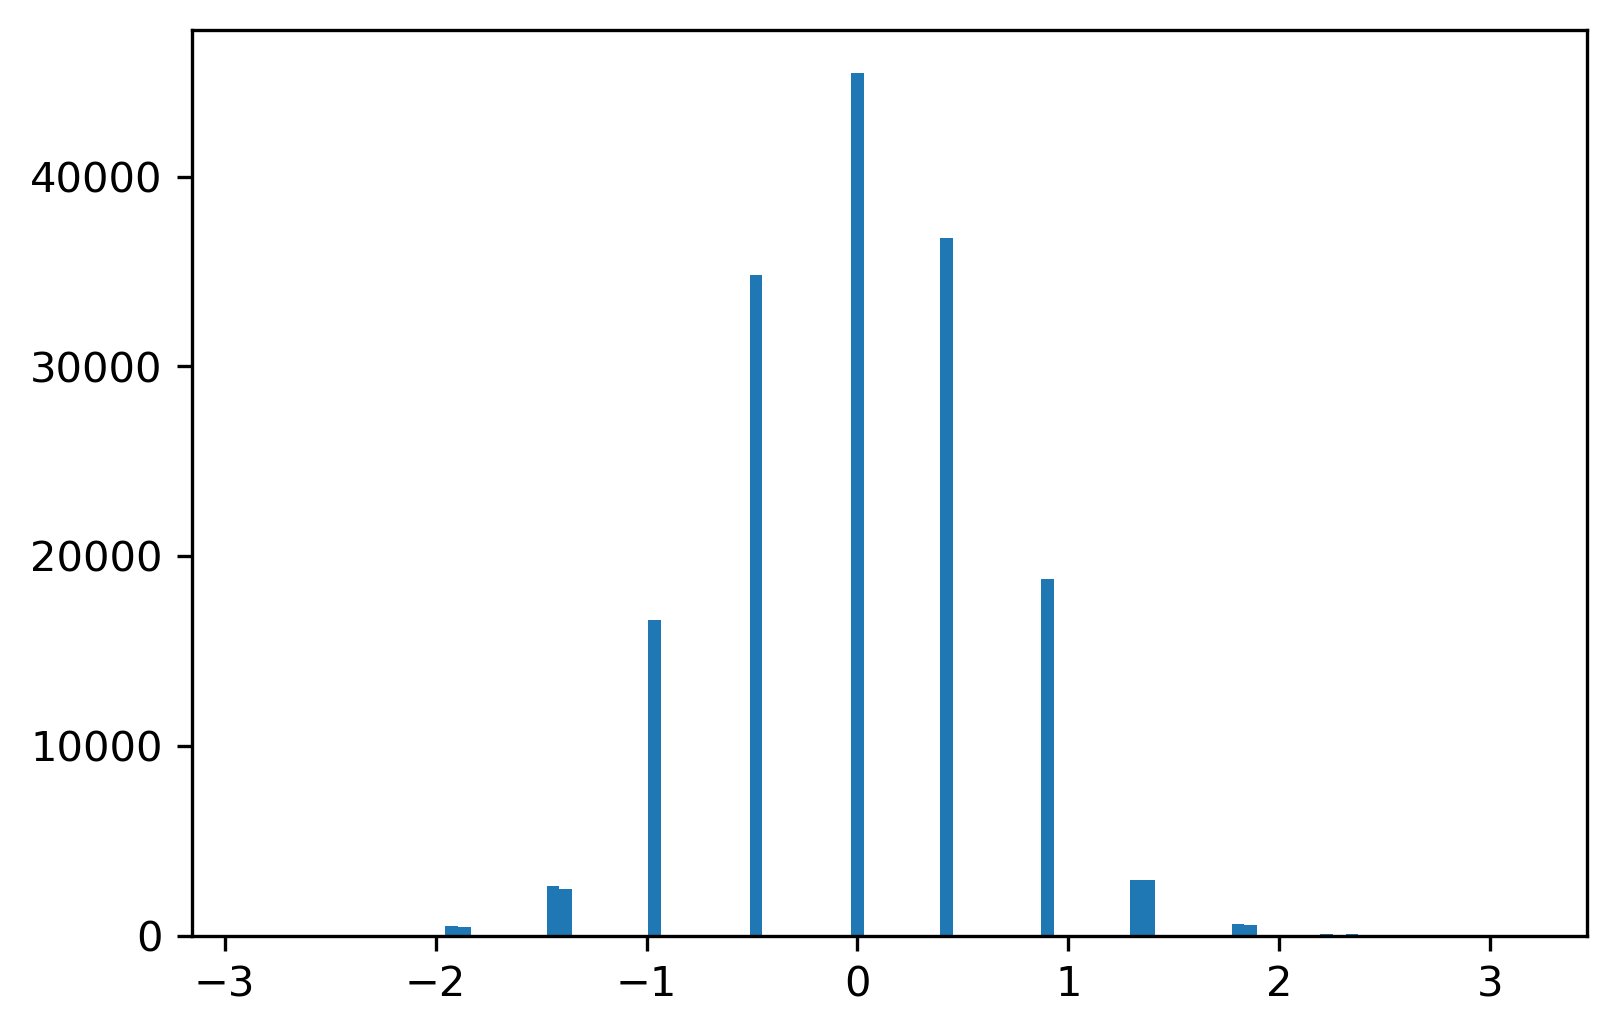

In [53]:
plt.hist(rechit[b'rechit_energy'][rechit[b'rechit_thickness'] > 200.0].flatten(),bins=100)
#plt.hist(rechit[b'rechit_layer'].flatten())

[3.4028235e+38 3.4028235e+38 3.4028235e+38 ... 3.4028235e+38 3.4028235e+38
 3.4028235e+38]


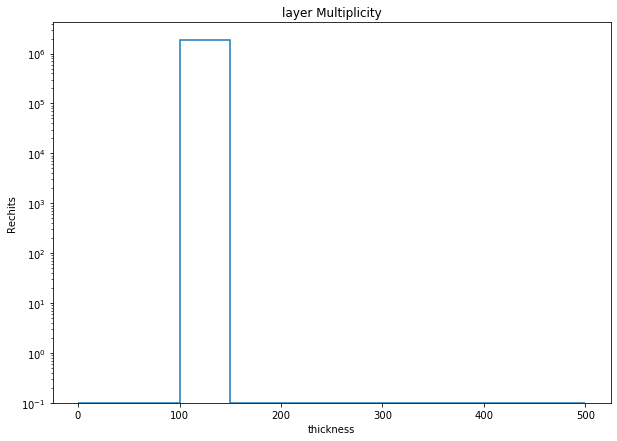

In [18]:
def plotHist_thickness(data, ylabel, title, xlabel="thickness", log=True):
    fig,axes = plt.subplots(figsize=(10, 7));
    axes.set_xlabel(xlabel)
#    axes.set_xticks(np.arange(53)+0.5, minor=True)
    axes.set_ylabel(ylabel)
    axes.set_title(title)
    axes.hist(data, range=(0,500), log=log, histtype='step', linewidth = '1.5');
    plt.grid(True, which='minor', axis='x', linewidth='0.5')
    return fig
figs.append(plotHist_thickness(rechit[b'rechit_thickness'].flatten(), "Rechits", "layer Multiplicity",log=True))
#rechit[b'rechit_thickness'][rechit[b'rechit_thickness'] < 301].content

print(rechit[b'rechit_thickness'][rechit[b'rechit_layer']==10].flatten())

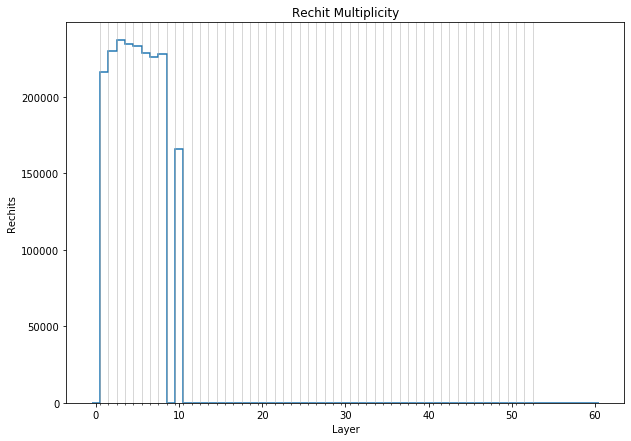

In [19]:
figs.append(plotHist_layers(rechit[b'rechit_layer'].flatten(), "Rechits", "Rechit Multiplicity",log=False))

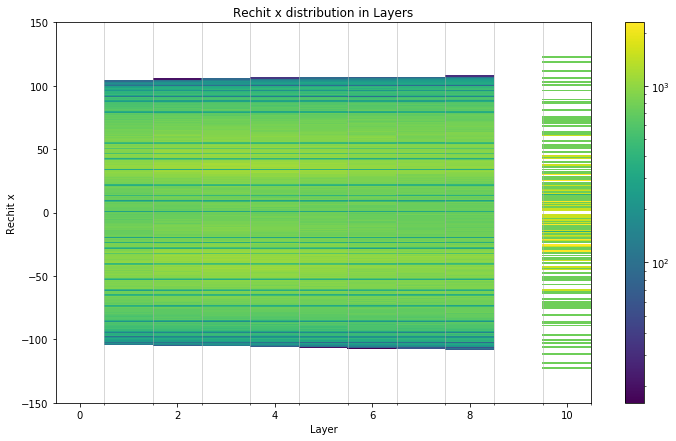

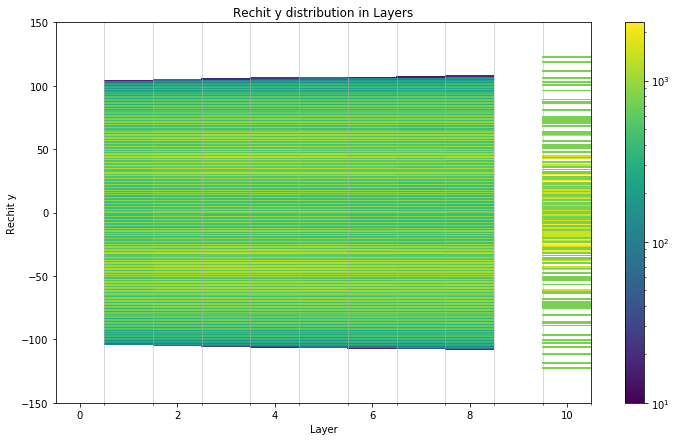

In [20]:
def plotRechitDistribution_Layers(rechit_layer, rechit_pos, title_target):
    fig,axes = plt.subplots(figsize=(12, 7));
    axes.set_xlabel("Layer")
    axes.set_ylabel("%s" % (title_target))
    axes.set_xticks(np.arange(53)+0.5, minor=True)
    axes.set_title("%s distribution in Layers" % (title_target))
    h = axes.hist2d(rechit_layer.content, rechit_pos.content, bins=(np.arange(12)-0.5, 500), range=((-0.5,10.5),(-150.0, 150.0)), norm=mpl.colors.LogNorm());
    plt.grid(True, which='minor', axis='x', linewidth='0.5')
    plt.colorbar(h[3], ax=axes);
    return fig

figs.append(plotRechitDistribution_Layers(rechit[b'rechit_layer'], rechit[b'rechit_x'], 'Rechit x'));
figs.append(plotRechitDistribution_Layers(rechit[b'rechit_layer'], rechit[b'rechit_y'], 'Rechit y'));

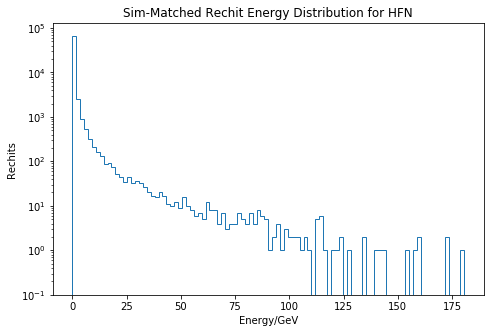

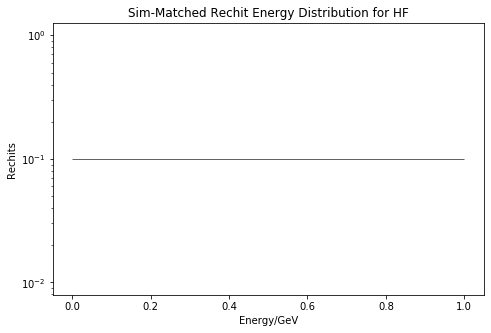

In [21]:
figs.append(plotRechitEnergy_Thickness(100, simmatched_rechit[b'rechit_energy'], simmatched_rechit[b'rechit_thickness'], "Sim-Matched Rechit"));
figs.append(plotRechitEnergy_Thickness(-1, simmatched_rechit[b'rechit_energy'], simmatched_rechit[b'rechit_thickness'], "Sim-Matched Rechit"));
#figs.append(plotRechitEnergy_Thickness(300, simmatched_rechit[b'rechit_energy'], simmatched_rechit[b'rechit_thickness'], "Sim-Matched Rechit"));
#figs.append(plotRechitEnergy_Thickness(-1, simmatched_rechit[b'rechit_energy'], simmatched_rechit[b'rechit_thickness'], "Sim-Matched Rechit"));

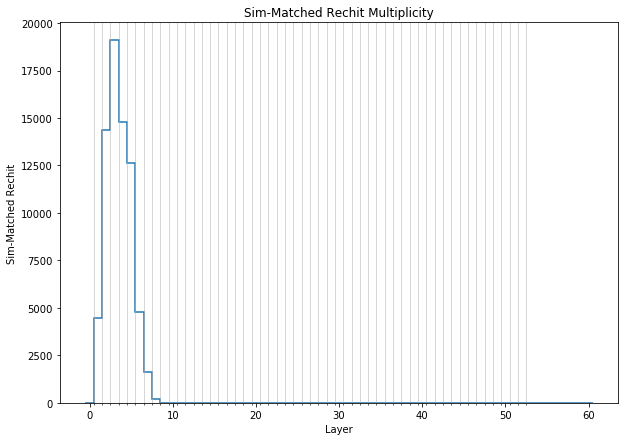

In [22]:
figs.append(plotHist_layers(simmatched_rechit[b'rechit_layer'].content, "Sim-Matched Rechit","Sim-Matched Rechit Multiplicity", log=False))

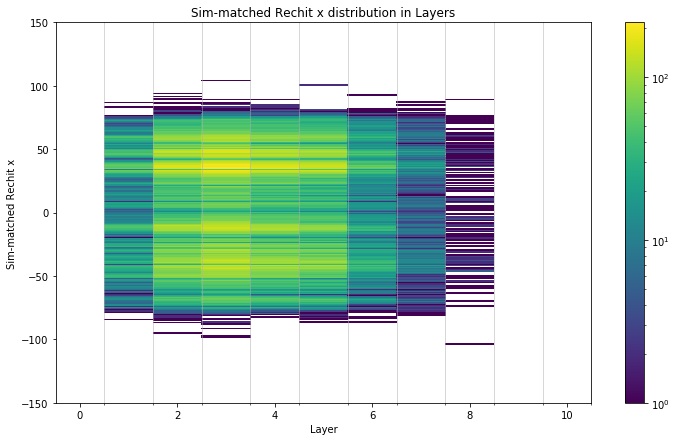

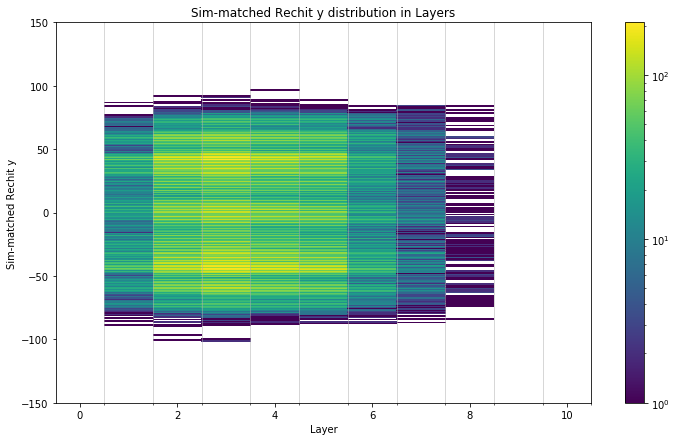

In [23]:
figs.append(plotRechitDistribution_Layers(simmatched_rechit[b'rechit_layer'], simmatched_rechit[b'rechit_x'], 'Sim-matched Rechit x'));
figs.append(plotRechitDistribution_Layers(simmatched_rechit[b'rechit_layer'], simmatched_rechit[b'rechit_y'], 'Sim-matched Rechit y'));


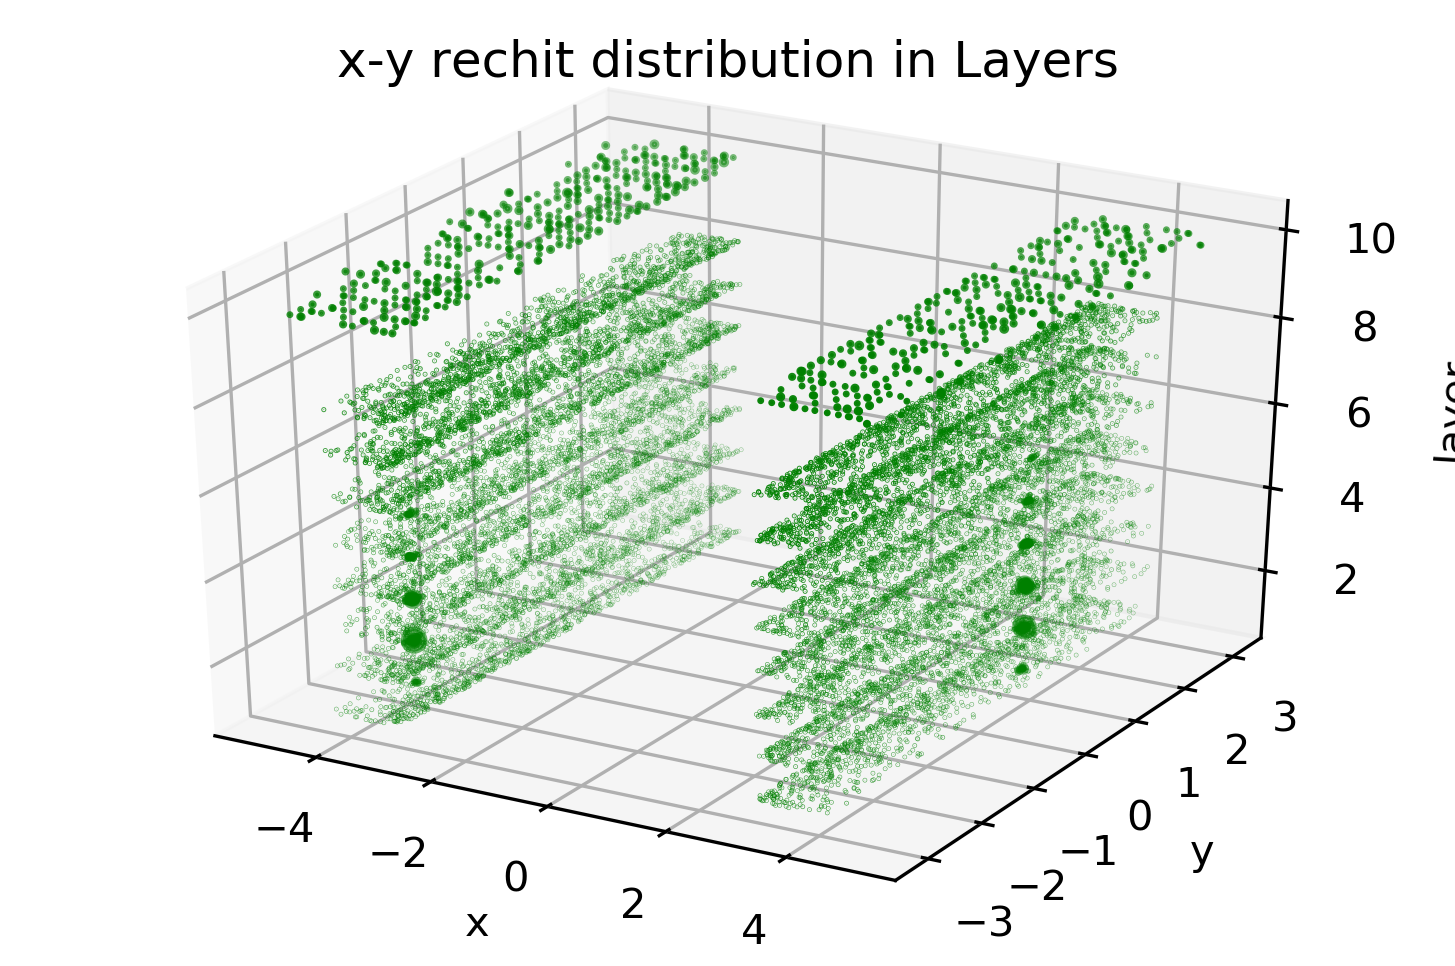

In [26]:
evt = 90
from mpl_toolkits import mplot3d
#%matplotlib qt 
import numpy as np
import matplotlib.pyplot as plt

#fig = plt.figure()
#ax = plt.axes(projection="3d")
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

#plt.show()

from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection="3d")

#z_line = np.linspace(0, 15, 1000)
#x_line = np.cos(z_line)
#y_line = np.sin(z_line)
#ax.plot3D(x_line, y_line, z_line, 'gray')

#z_points = 15 * np.random.random(100)
#x_points = np.cos(z_points) + 0.1 * np.random.randn(100)
#y_points = np.sin(z_points) + 0.1 * np.random.randn(100)
#ax.scatter3D(simmatched_rechit[b'rechit_x'][evt], simmatched_rechit[b'rechit_y'][evt], simmatched_rechit[b'rechit_layer'][evt], s=simmatched_rechit[b'rechit_energy'][evt],c='b');
ax.scatter3D(rechit[b'rechit_eta'][evt], rechit[b'rechit_phi'][evt], rechit[b'rechit_layer'][evt], s=rechit[b'rechit_energy'][evt],c='g');
#ax.scatter3D(simmatched_rechit[b'rechit_x'][evt], simmatched_rechit[b'rechit_y'][evt], simmatched_rechit[b'rechit_layer'][evt], s=simmatched_rechit[b'rechit_energy'][evt],c='b');
#ax.scatter3D(simmatched_rechit[b'rechit_x'][simmatched_rechit[b'rechit_z'] > 0][evt], simmatched_rechit[b'rechit_y'][simmatched_rechit[b'rechit_z'] > 0][evt], simmatched_rechit[b'rechit_layer'][simmatched_rechit[b'rechit_z'] > 0][evt], s=simmatched_rechit[b'rechit_energy'][simmatched_rechit[b'rechit_z'] > 0][evt],c='b');
#ax.scatter3D(simmatched_rechit[b'rechit_x'][simmatched_rechit[b'rechit_z'] < 0][evt], simmatched_rechit[b'rechit_y'][simmatched_rechit[b'rechit_z'] < 0][evt], simmatched_rechit[b'rechit_layer'][simmatched_rechit[b'rechit_z'] < 0][evt], s=simmatched_rechit[b'rechit_energy'][simmatched_rechit[b'rechit_z'] < 0][evt],c='r');

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('layer')
#ax.set_ylim([-5,0])
#ax.set_xlim([-5,0])
#ax.set_title("x-y simmatched rechit distribution in Layers")
ax.set_title("x-y rechit distribution in Layers")
plt.show()


In [ ]:
#for i in range (NEvents):
#    print('event:',i,'rechit collection size:',simmatched_rechit[b'rechit_y'][i].shape[0])


In [ ]:
evt = 13
print('rechit size:',rechit[b'rechit_energy'][evt].shape)
print('unique valid simindices size:',(valid_sim_indices_eventlevel[evt]).shape)
print('max simindex:',max(valid_sim_indices_eventlevel[evt]))
print('min simindex:',min(valid_sim_indices_eventlevel[evt]))